In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [30]:
torch.cuda.empty_cache()
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
market_kwargs = dict(start_volumes=10,
                     base_price=10,
                     start_gains=500,
                     deprecation_steps=3,
                     min_price=1,
                     max_price=100)
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),
]
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
]
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         target='production',
                         batch_size=1)
critic = CentralizedCritic2
trainer = TrainerSAC(env, q_critic=critic, batch_size=512, buffer_size=524288, learning_rates=(1e-3, 1e-3))

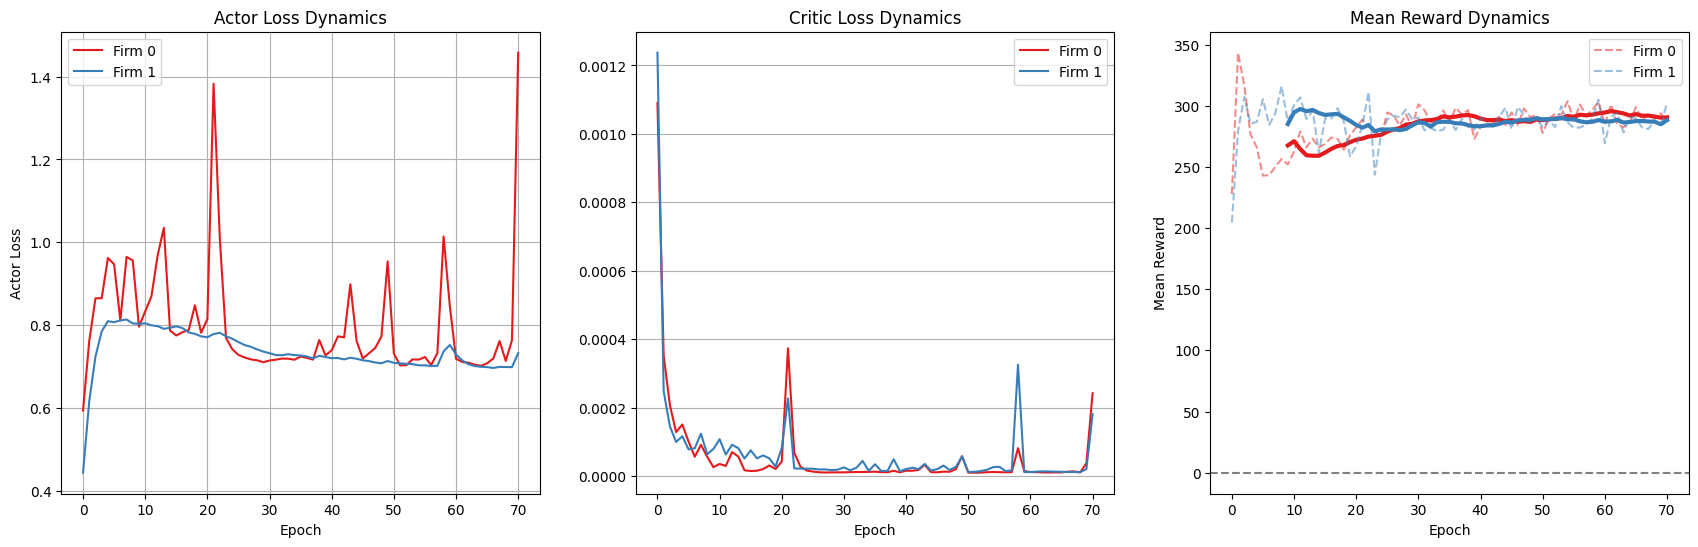

  7%|████▎                                                       | 71/1000 [01:01<13:45,  1.13it/s, LR=0.000701, Buffer Index=229376, Order=[0, 1]]

In [ ]:
env.change_batch_size(1024)
env.reset()
trainer.train(1000, episode_length=32, shuffle_order=False)

In [ ]:
env = trainer.environment
env.reset()
env.change_batch_size(1)

In [20]:
env.market
env.firms

[Firm id: 0
 Reserves: [[10, 10]]
 Finance: tensor([[500]], device='cuda:0')
 Limit: tensor([[2]], device='cuda:0')
 Capital: tensor([[2, 0, 0, 0]], device='cuda:0'),
 Firm id: 1
 Reserves: [[10, 10]]
 Finance: tensor([[500]], device='cuda:0')
 Limit: tensor([[2]], device='cuda:0')
 Capital: tensor([[2, 0, 0, 0]], device='cuda:0')]

In [21]:
n_periods = 256
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
# env.firms

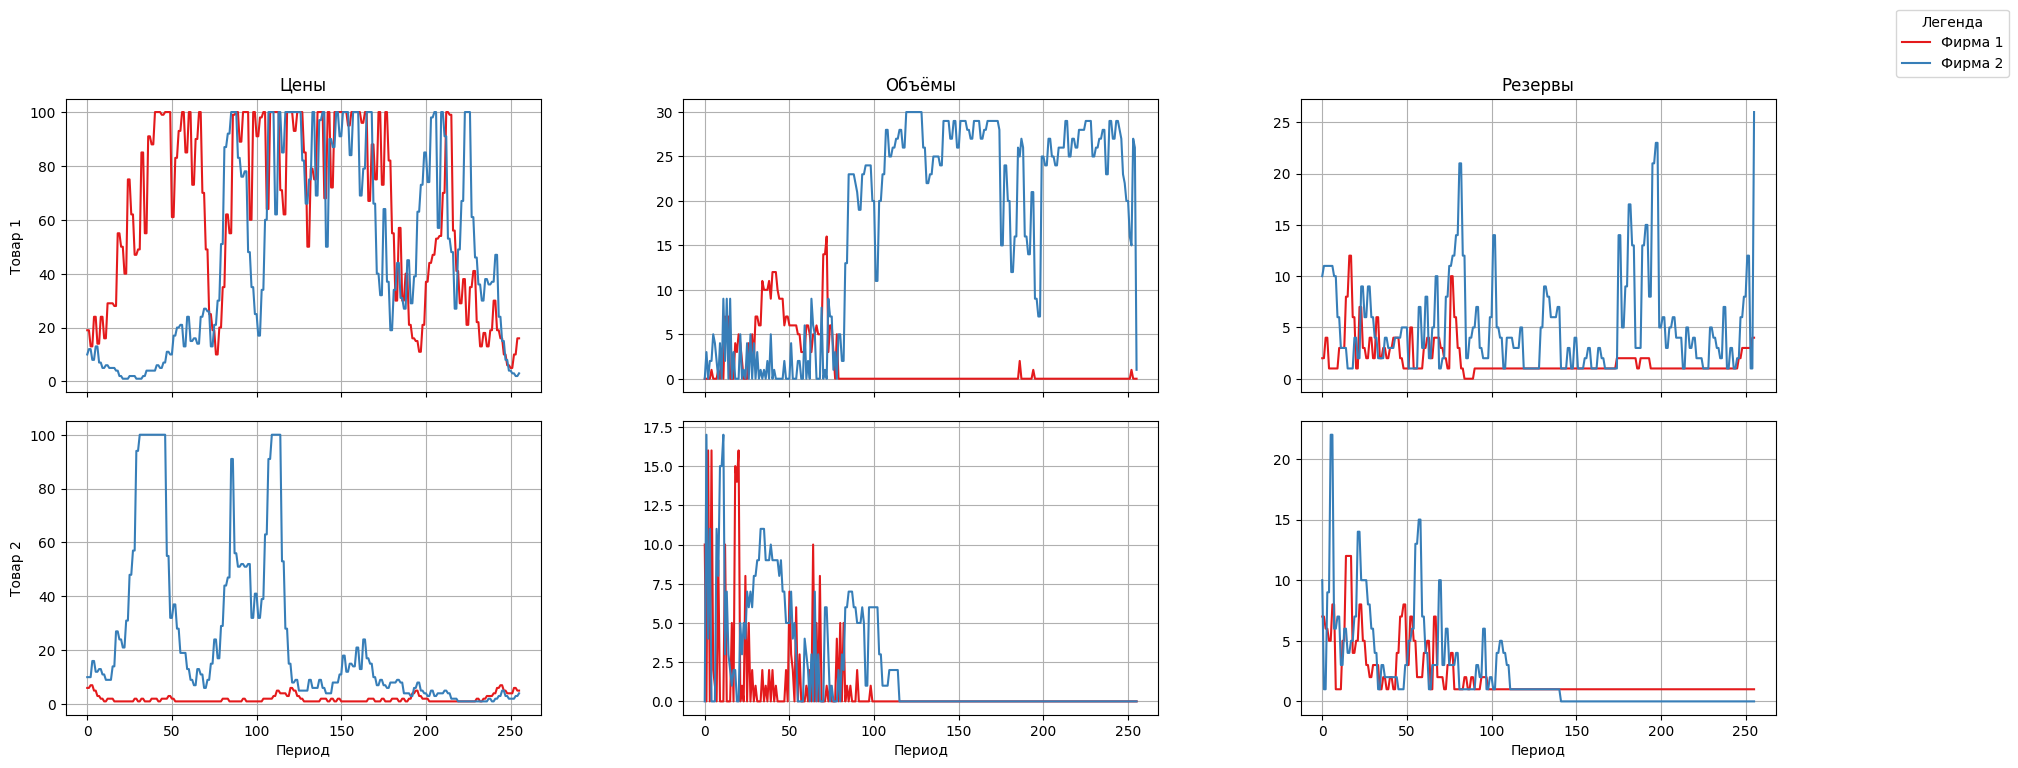

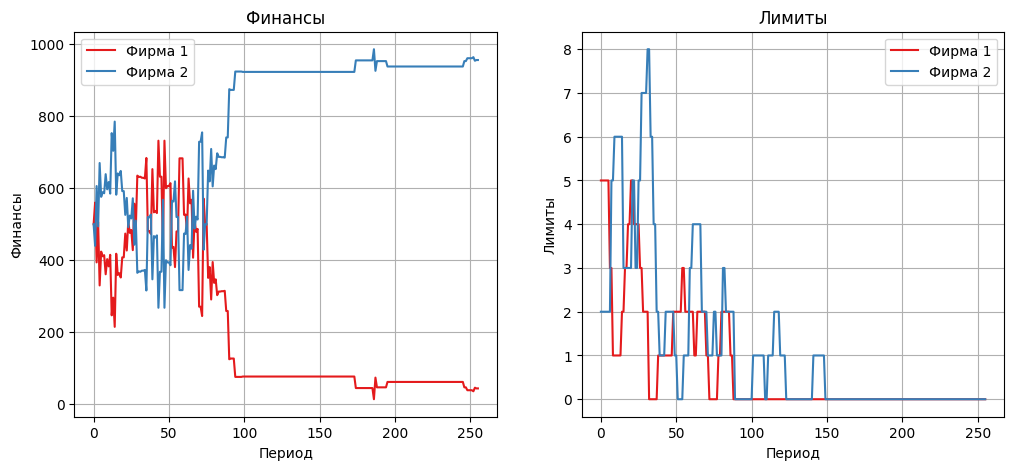

In [22]:
from utils.plotting import plot_actions, plot_environment

plot_environment(env.state_history)

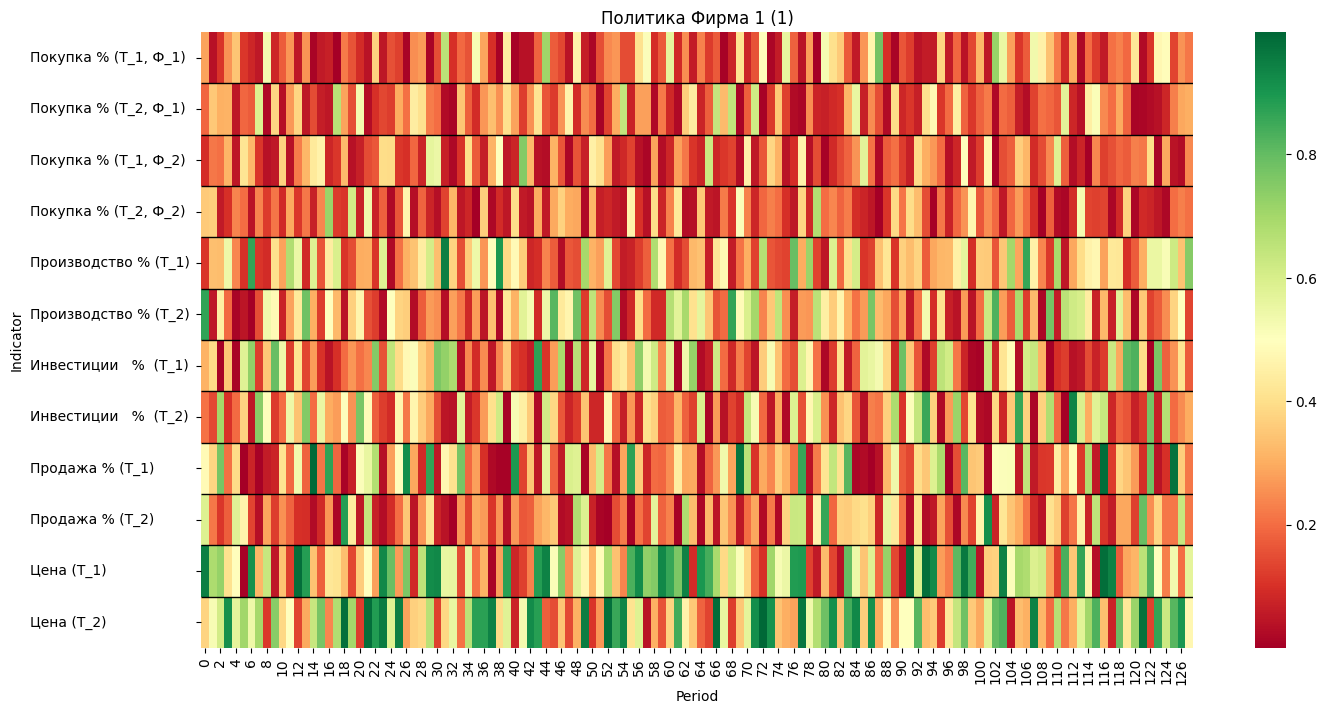

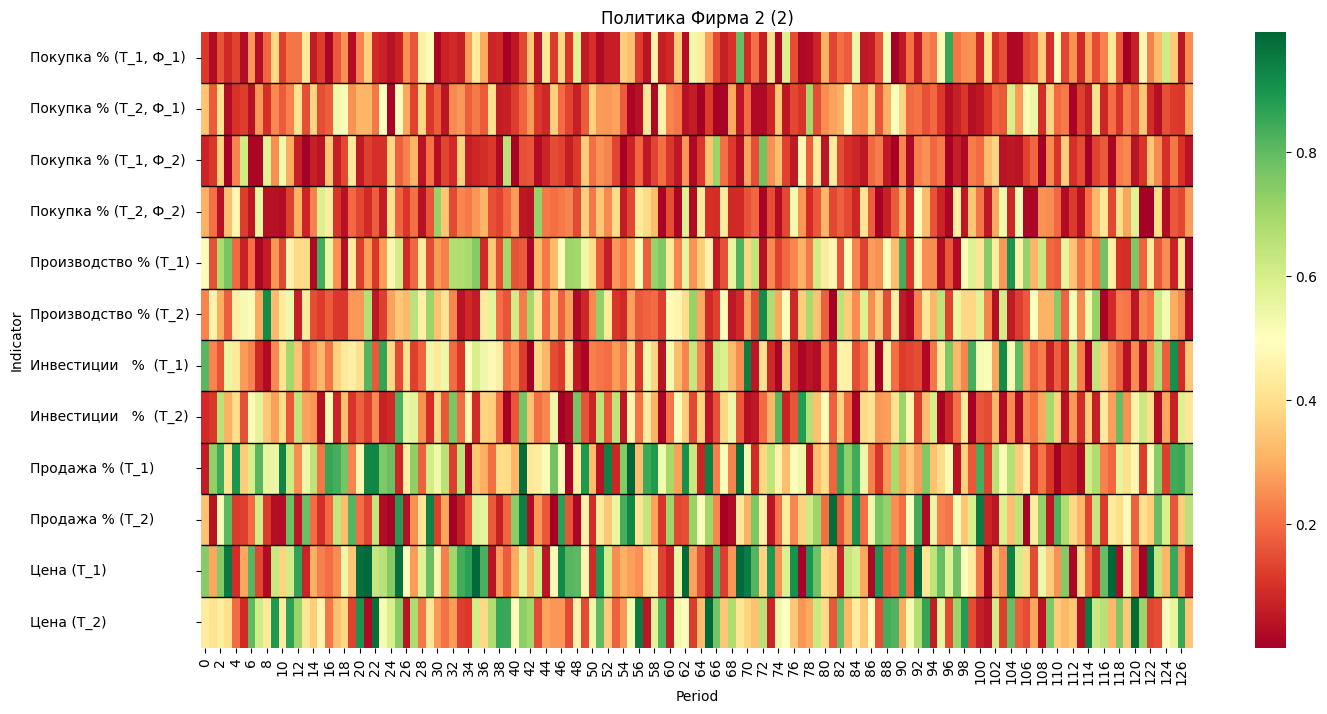

In [9]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')